In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_datareader import data, wb
import datetime
import tensorflow as tf
from datetime import date, timedelta
%matplotlib inline

In [2]:
start = datetime.datetime(2005, 1, 1)
end = datetime.datetime(2020, 1, 1)

In [3]:
bank="JPM"
stocks = data.DataReader(bank, 'yahoo', start, end)

In [4]:
stocks.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2004-12-31,39.169998,38.950001,39.080002,39.009998,5754000.0,24.427862
2005-01-03,39.689999,39.009998,39.480000,39.150002,14957900.0,24.515543
2005-01-04,39.060001,38.320000,38.980000,38.410000,11360900.0,24.262869
2005-01-05,38.919998,38.389999,38.599998,38.490002,9770200.0,24.313406
2005-01-06,38.980000,38.639999,38.770000,38.709999,9115900.0,24.452362


Text(0, 0.5, 'Opening Stock Price')

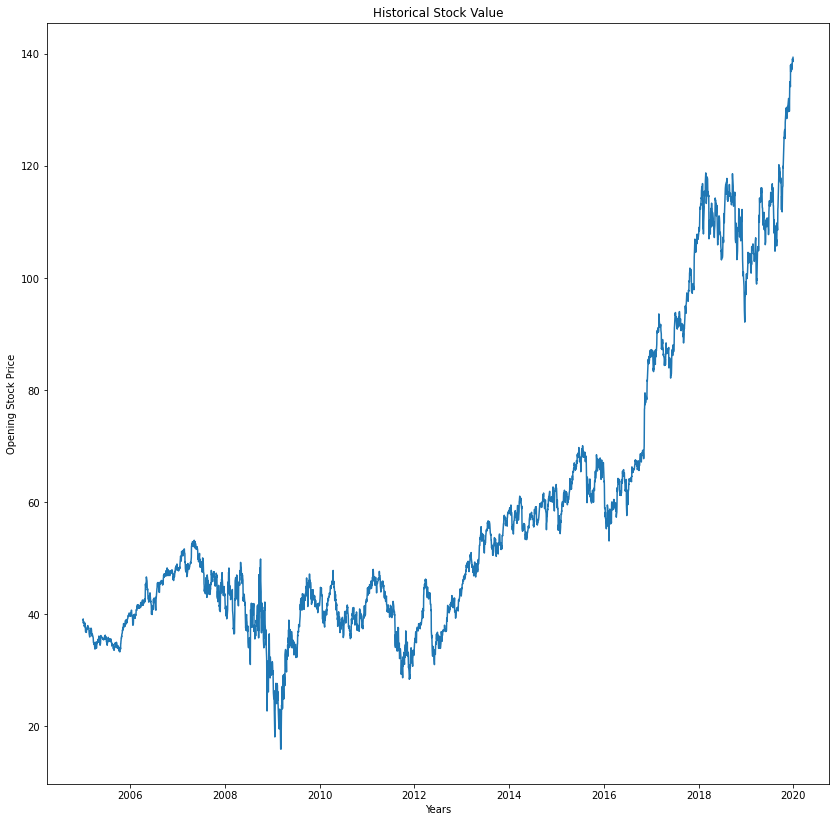

In [5]:
plt.figure(figsize=(14,14))
plt.plot(stocks['Close'])
plt.title('Historical Stock Value')
plt.xlabel('Years')
plt.ylabel('Opening Stock Price')

In [6]:
df=stocks.reset_index()['Close']

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [8]:
train_size=int(len(df)*0.70)
test_size=len(df)-train_size
train_data=df[0:train_size]
test_data=df[train_size:]

In [9]:
def make_dataset(data,timestep):
    X=[]
    y=[]
    n=len(data)
    for i in range(0,n-timestep-1):
        X.append(data[i:i+timestep])
        y.append(data[i+timestep])
    return np.array(X),np.array(y)

In [10]:
timestep=30
X_train,y_train=make_dataset(train_data,timestep)
X_test,y_test=make_dataset(test_data,timestep)
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [12]:
model=Sequential()
model.add(LSTM(40,return_sequences=True,input_shape=(timestep,1)))
model.add(LSTM(40,return_sequences=True))
model.add(LSTM(40))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam') ##Stacked LSTM

In [13]:
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Bidirectional
from keras.datasets import imdb 

In [14]:
modelBD = Sequential()
modelBD.add(Bidirectional(LSTM(64)))
modelBD.add(Dropout(0.5))
modelBD.add(Dense(1,activation='sigmoid'))
modelBD.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']) ## Creating Bi-Directional LSTM

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 40)            6720      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 40)            12960     
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 32,681
Trainable params: 32,681
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=70,batch_size=40,verbose=1)

Epoch 1/70
66/66 [==============================] - 7s 41ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 2/70
66/66 [==============================] - 2s 26ms/step - loss: 3.3722e-04 - val_loss: 0.0015
Epoch 3/70
66/66 [==============================] - 2s 26ms/step - loss: 3.2386e-04 - val_loss: 9.5105e-04
Epoch 4/70
66/66 [==============================] - 2s 27ms/step - loss: 3.2490e-04 - val_loss: 0.0020
Epoch 5/70
66/66 [==============================] - 2s 29ms/step - loss: 3.1152e-04 - val_loss: 0.0015
Epoch 6/70
66/66 [==============================] - 2s 28ms/step - loss: 2.9668e-04 - val_loss: 0.0012
Epoch 7/70
66/66 [==============================] - 2s 27ms/step - loss: 2.7796e-04 - val_loss: 0.0015
Epoch 8/70
66/66 [==============================] - 2s 28ms/step - loss: 2.4947e-04 - val_loss: 0.0018
Epoch 9/70
66/66 [==============================] - 2s 28ms/step - loss: 2.4679e-04 - val_loss: 5.4995e-04
Epoch 10/70
66/66 [==============================] - 2s 30ms/step - l

In [17]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [18]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [19]:
import math
from sklearn.metrics import mean_squared_error 

In [20]:
train_predict

array([[37.24192 ],
       [37.265213],
       [37.30535 ],
       ...,
       [69.093575],
       [69.563896],
       [67.30879 ]], dtype=float32)

In [21]:
test_predict

array([[ 68.240585],
       [ 68.562485],
       [ 68.70134 ],
       ...,
       [138.93147 ],
       [140.66559 ],
       [139.2747  ]], dtype=float32)

In [22]:
lookback=timestep
trainPlot=np.empty_like(df)
trainPlot[:,:]=np.nan
trainPlot[lookback:len(train_predict)+lookback, :]=train_predict

testPlot=np.empty_like(df)
testPlot[:, :]=np.nan
testPlot[len(train_predict)+(lookback*2)+1:len(df)-1, :]=test_predict

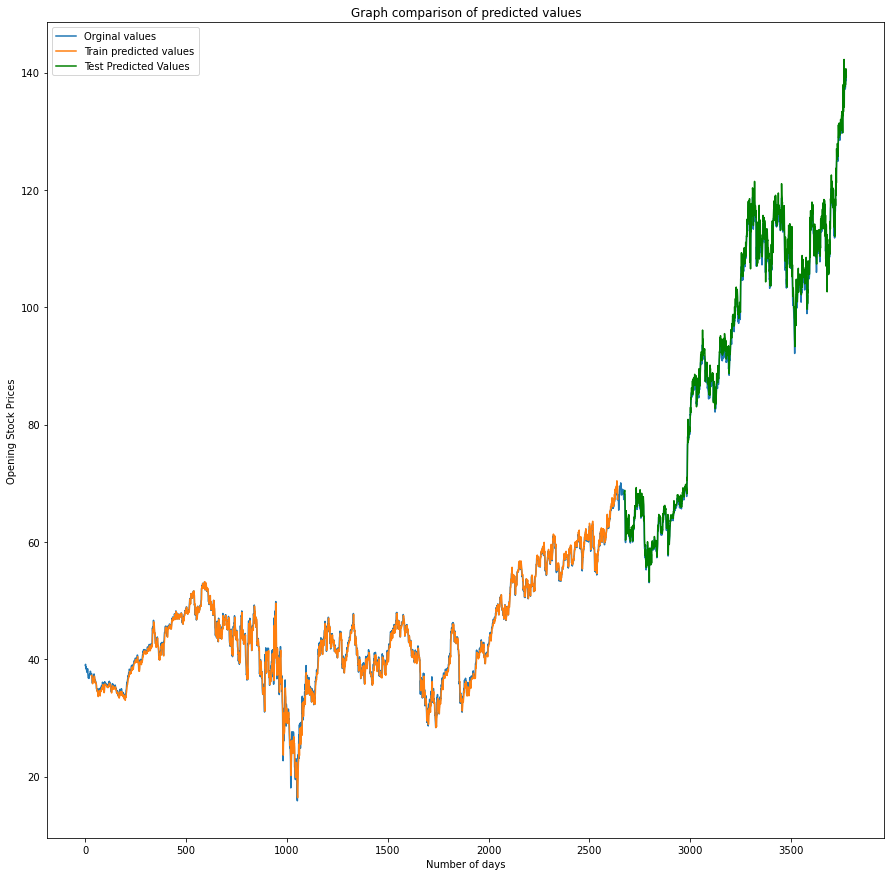

In [23]:
plt.figure(figsize=(15,15))
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPlot)
plt.plot(testPlot,color='g')
plt.title('Graph comparison of predicted values')
plt.xlabel('Number of days')
plt.ylabel('Opening Stock Prices')
plt.legend(['Orginal values','Train predicted values','Test Predicted Values'],loc=2)

In [24]:
def errorpercentage(y_test,pred):
    mape=np.mean(np.abs(y_test-pred)/y_test*100)
    return mape

In [25]:
print('Accuracy using Stacked LSTM',100-errorpercentage(scaler.inverse_transform(y_test),test_predict))

Accuracy using Stacked LSTM 98.53334129822098


In [26]:
a=test_data.shape[0]
x=test_data[a-timestep:]
scaler.inverse_transform(x)

array([[130.61999512],
       [130.58000183],
       [129.63000488],
       [129.92999268],
       [130.78999329],
       [131.49000549],
       [131.66999817],
       [132.05999756],
       [131.75999451],
       [131.47000122],
       [129.77999878],
       [132.33999634],
       [133.05999756],
       [135.03999329],
       [134.41000366],
       [134.5       ],
       [134.17999268],
       [138.02000427],
       [136.80999756],
       [137.33999634],
       [138.17999268],
       [138.03999329],
       [137.3500061 ],
       [137.24000549],
       [137.19999695],
       [137.58000183],
       [139.03999329],
       [139.13999939],
       [138.63000488],
       [139.3999939 ]])

In [27]:
x.shape

(30, 1)

In [28]:
pred_stocks = data.DataReader(bank, 'yahoo', end+timedelta(1), end+timedelta(22))## reading data for next 15 days

In [29]:
pred_stocks

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,141.100006,139.259995,139.789993,141.089996,10803700.0,131.047974
2020-01-03,139.229996,137.080002,137.500000,138.339996,10386800.0,129.318619
2020-01-06,138.270004,136.500000,136.559998,138.229996,10259000.0,129.215790
2020-01-07,137.860001,135.820007,137.279999,135.880005,10531300.0,127.019058
2020-01-08,137.580002,135.600006,135.699997,136.940002,9695300.0,128.009918
2020-01-09,138.229996,137.039993,138.050003,137.440002,9469000.0,128.477310
2020-01-10,137.250000,135.809998,137.210007,136.070007,10190900.0,127.196663
2020-01-13,137.199997,135.759995,136.190002,137.199997,12355200.0,128.252975
2020-01-14,140.759995,137.690002,137.940002,138.800003,24906000.0,129.748642


In [30]:
actual_values=[]
for i in pred_stocks['Open']:
    actual_values.append(i)
actual_values=np.array(actual_values)

In [31]:
actual_values

array([139.78999329, 137.5       , 136.55999756, 137.27999878,
       135.69999695, 138.05000305, 137.21000671, 136.19000244,
       137.94000244, 137.8500061 , 137.44999695, 137.53999329,
       137.19000244, 137.24000549, 135.71000671])

In [32]:
## Prediction for next 15 days
i=0
while(i<15):
    length_of_array=len(x)
    if(length_of_array==timestep):
        temp=x;
        temp=temp.reshape(1,timestep,1)
        yget=model.predict(temp)
        x=np.append(x,yget)
    else:
        temp=x[length_of_array-timestep:]
        temp=temp.reshape(1,timestep,1)
        yget=model.predict(temp)
        x=np.append(x,yget)
    i=i+1 

In [33]:
x=x.reshape(-1,1)
actual_values=actual_values.reshape(-1,1)
scaler.inverse_transform(x[timestep:])

array([[140.9167931 ],
       [142.28620689],
       [143.32157063],
       [144.14491786],
       [144.89353447],
       [145.63178653],
       [146.36239771],
       [147.06437391],
       [147.72003362],
       [148.32359094],
       [148.87840257],
       [149.39143218],
       [149.86880427],
       [150.31518582],
       [150.73469908]])

In [34]:
act,pred=actual_values[:i],scaler.inverse_transform(x[timestep:])

In [35]:
scaler.inverse_transform(x[timestep:])

array([[140.9167931 ],
       [142.28620689],
       [143.32157063],
       [144.14491786],
       [144.89353447],
       [145.63178653],
       [146.36239771],
       [147.06437391],
       [147.72003362],
       [148.32359094],
       [148.87840257],
       [149.39143218],
       [149.86880427],
       [150.31518582],
       [150.73469908]])

In [36]:
print('Accuracy for Future 15 days values',100-errorpercentage(act,pred))

Accuracy for Future 15 days values 93.15864228253751


In [37]:
from sklearn.metrics import mean_absolute_error

In [38]:
print('MSE for future 15 days values',mean_absolute_error(act,pred))

MSE for future 15 days values 9.376914490798633


In [39]:
y=len(df)-1460
Plotarr=np.empty([y+15,1])
Plotarr[::]=np.nan
Plotarr[y:]=pred

In [40]:
pred    ## stocks for the next 15 days 

array([[140.9167931 ],
       [142.28620689],
       [143.32157063],
       [144.14491786],
       [144.89353447],
       [145.63178653],
       [146.36239771],
       [147.06437391],
       [147.72003362],
       [148.32359094],
       [148.87840257],
       [149.39143218],
       [149.86880427],
       [150.31518582],
       [150.73469908]])

In [41]:
print('The above shows the predicted stock price for 15 days')

The above shows the predicted stock price for 15 days


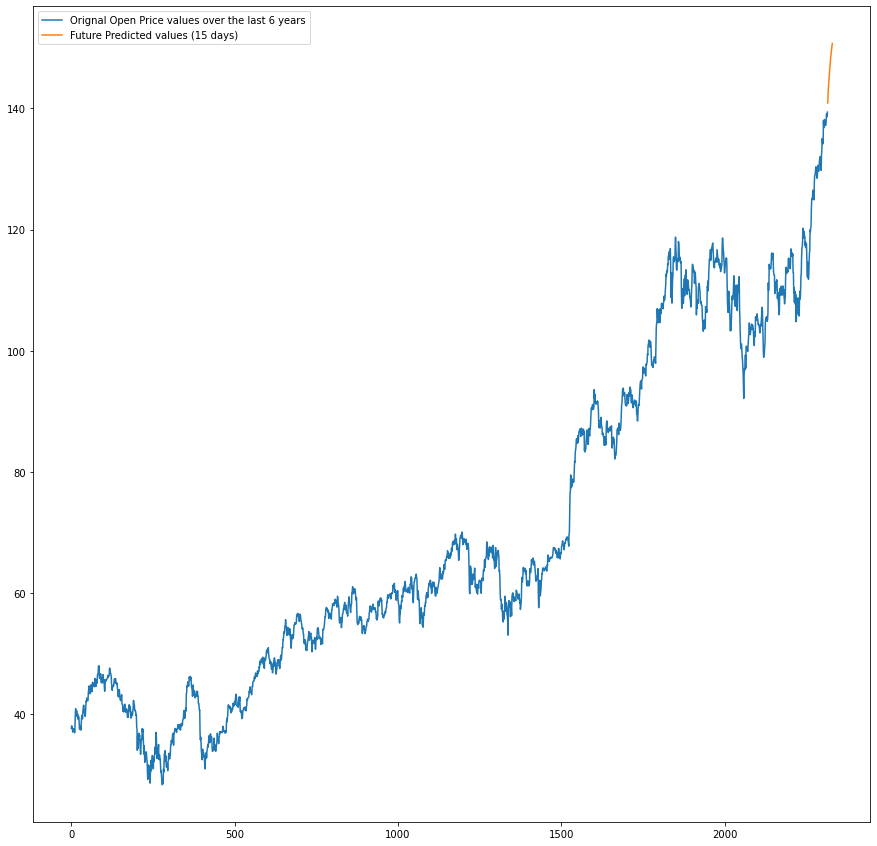

In [42]:
plt.figure(figsize=(15,15))
plt.plot(scaler.inverse_transform(df[1460:])) ## for the 
plt.plot(Plotarr)
plt.legend(['Orignal Open Price values over the last 6 years','Future Predicted values (15 days)'],loc=2)

In [43]:
f=pd.DataFrame(pred,columns=['Close'])

In [44]:
string=bank+'Data'
dfnew=pd.read_csv(string)

In [45]:
dfnew['Close']=pred

In [46]:
dfnew.to_csv(string,index=False)

In [47]:
test=pd.read_csv(string)

In [48]:
dfnew

,Close,Open
0,140.916793,136.761414
1,142.286207,135.792383
2,143.321571,135.302731
3,144.144918,134.936249
4,144.893534,134.564193
5,145.631787,134.173618
6,146.362398,133.792462
7,147.064374,133.444566
8,147.720034,133.137591
9,148.323591,132.867454


In [49]:
modelBD.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=70,batch_size=40,verbose=1)

Epoch 1/70
66/66 [==============================] - 4s 22ms/step - loss: 0.5699 - accuracy: 3.8285e-04 - val_loss: 1.1659 - val_accuracy: 0.0000e+00
Epoch 2/70
66/66 [==============================] - 1s 14ms/step - loss: 0.5361 - accuracy: 3.8285e-04 - val_loss: 0.6930 - val_accuracy: 0.0000e+00
Epoch 3/70
66/66 [==============================] - 1s 14ms/step - loss: 0.5263 - accuracy: 3.8285e-04 - val_loss: 0.6543 - val_accuracy: 0.0000e+00
Epoch 4/70
66/66 [==============================] - 1s 14ms/step - loss: 0.5257 - accuracy: 3.8285e-04 - val_loss: 0.6480 - val_accuracy: 0.0000e+00
Epoch 5/70
66/66 [==============================] - 1s 14ms/step - loss: 0.5257 - accuracy: 3.8285e-04 - val_loss: 0.6454 - val_accuracy: 0.0000e+00
Epoch 6/70
66/66 [==============================] - 1s 14ms/step - loss: 0.5255 - accuracy: 3.8285e-04 - val_loss: 0.6453 - val_accuracy: 0.0000e+00
Epoch 7/70
66/66 [==============================] - 1s 15ms/step - loss: 0.5254 - accuracy: 3.8285e-04 - v

Epoch 56/70
66/66 [==============================] - 1s 17ms/step - loss: 0.5240 - accuracy: 3.8285e-04 - val_loss: 0.6108 - val_accuracy: 0.0000e+00
Epoch 57/70
66/66 [==============================] - 1s 16ms/step - loss: 0.5240 - accuracy: 3.8285e-04 - val_loss: 0.6107 - val_accuracy: 0.0000e+00
Epoch 58/70
66/66 [==============================] - 1s 16ms/step - loss: 0.5239 - accuracy: 3.8285e-04 - val_loss: 0.6071 - val_accuracy: 0.0000e+00
Epoch 59/70
66/66 [==============================] - 1s 16ms/step - loss: 0.5239 - accuracy: 3.8285e-04 - val_loss: 0.6071 - val_accuracy: 0.0000e+00
Epoch 60/70
66/66 [==============================] - 1s 16ms/step - loss: 0.5238 - accuracy: 3.8285e-04 - val_loss: 0.6084 - val_accuracy: 0.0000e+00
Epoch 61/70
66/66 [==============================] - 1s 16ms/step - loss: 0.5239 - accuracy: 3.8285e-04 - val_loss: 0.6085 - val_accuracy: 0.0000e+00
Epoch 62/70
66/66 [==============================] - 1s 16ms/step - loss: 0.5238 - accuracy: 3.8285e

In [50]:
train_predict=modelBD.predict(X_train)
test_predict=modelBD.predict(X_test)

In [51]:
trypredict=scaler.inverse_transform(test_predict)

In [52]:
trypredict

array([[ 68.09296],
       [ 68.0249 ],
       [ 67.99406],
       ...,
       [111.45377],
       [111.53127],
       [111.62241]], dtype=float32)

In [53]:
print('Accuracy using Bi-directional LSTM',100-errorpercentage(scaler.inverse_transform(y_test),trypredict))

Accuracy using Bi-directional LSTM 94.9745719321153
